<a href="https://colab.research.google.com/github/shrabonbiswas/Thesis/blob/main/Copy_of_MDD_with_DAA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import library

In [3]:
import numpy as np
import pandas as pd
import os
import cv2
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread


In [4]:
import os
import shutil

# Source: Google Drive file
src_file = "/content/drive/MyDrive/Thesis/dataset/thesis.zip"

# Destination: Colab local directory
dest_file = "/content/thesis.zip"

# ফাইল আছে কিনা চেক করা
if os.path.exists(src_file):
    shutil.copy(src_file, dest_file)
    print("✅ File copied successfully!")
else:
    print(f"❌ Source file পাওয়া যায়নি: {src_file}")

✅ File copied successfully!


In [5]:
import zipfile
import os

zip_path = '/content/thesis.zip'
extract_path = '/content/extracted_thesis'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ File extracted to: {extract_path}")

✅ File extracted to: /content/extracted_thesis


In [6]:
import os

dest_path = "/content/extracted_thesis/data"
dataset_path = dest_path

total_images = 0
class_counts = {}

for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        num_images = len([
            f for f in os.listdir(class_dir)
            if os.path.isfile(os.path.join(class_dir, f))
        ])
        class_counts[class_name] = num_images
        total_images += num_images

print(f"\n✅ Total number of images: {total_images}")
print(f"✅ Number of classes: {len(class_counts)}")
print("📊 Images per class:")
for cls, count in class_counts.items():
    print(f"  {cls}: {count} images")



✅ Total number of images: 4188
✅ Number of classes: 4
📊 Images per class:
  Gray_Leaf_Spot: 574 images
  Common_Rust: 1306 images
  Healthy: 1162 images
  Blight: 1146 images


📌 Selected Image: Corn_Blight (574).JPG


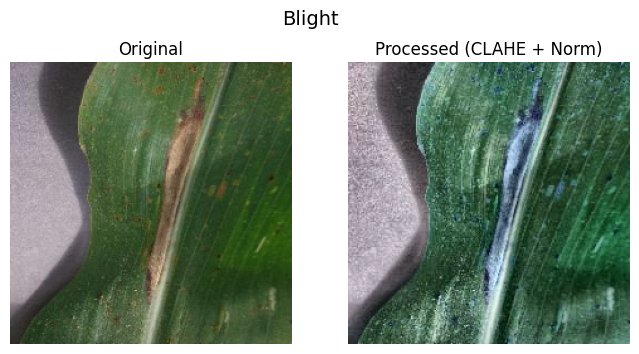

In [7]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import random   # নতুন যোগ করা হয়েছে

# ✅ ইনপুট এবং আউটপুট ফোল্ডার
input_folder = dest_path
output_folder = 'blight_dataset_processed'

# ✅ টার্গেট সাইজ
target_size = (224, 224)

# ✅ CLAHE সেটআপ
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# ✅ Image preprocessing ফাংশন
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None, None

    img_resized = cv2.resize(img, target_size)

    # CLAHE প্রয়োগ
    lab = cv2.cvtColor(img_resized, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    # Normalization
    img_normalized = img_clahe.astype('float32') / 255.0

    return img_resized, img_normalized

# ✅ Image Preview ফাংশন
def show_images(original, processed, title=''):
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(processed)
    plt.title('Processed (CLAHE + Norm)')
    plt.axis('off')

    plt.suptitle(title, fontsize=14)
    plt.show()

# ✅ 'blight' ক্লাস থেকে random একটি ছবি নেওয়া
all_classes = [d for d in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, d))]
blight_classes = [c for c in all_classes if 'blight' in c.lower()]

if not blight_classes:
    print("❌ 'blight' নামের কোনো ক্লাস পাওয়া যায়নি!")
    print("ℹ️ Available classes:", all_classes)
else:
    sample_class = blight_classes[0]   # প্রথম blight ক্লাসটি নিলাম
    class_dir = os.path.join(input_folder, sample_class)
    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    if not images:
        print(f"❌ '{sample_class}' ক্লাসে কোনো ছবি পাওয়া যায়নি!")
    else:
        sample_img = random.choice(images)   # 🎲 random একটি ইমেজ বাছাই
        img_path = os.path.join(class_dir, sample_img)

        original_img, processed_img = preprocess_image(img_path)
        if original_img is None:
            print("❌ ছবিটি পড়া যায়নি:", img_path)
        else:
            print(f"📌 Selected Image: {sample_img}")
            show_images(original_img, processed_img, title=sample_class)


In [8]:
# ✅ batch preprocessing + save
for class_name in os.listdir(input_folder):
    class_path = os.path.join(input_folder, class_name)
    if not os.path.isdir(class_path):
        continue

    save_class_path = os.path.join(output_folder, class_name)
    os.makedirs(save_class_path, exist_ok=True)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        save_path = os.path.join(save_class_path, img_name)

        original_img, processed_img = preprocess_image(img_path)
        if processed_img is not None:
            # [0,1] → [0,255] → uint8 → BGR
            processed_img_uint8 = (processed_img * 255).astype('uint8')
            cv2.imwrite(save_path, processed_img_uint8)

In [9]:
classwise_hsv_ranges = {
    'Blight':         ([0, 0, 0], [180, 255, 255]),
    'Gray_Leaf_Spot': ([0, 0, 0], [180, 255, 255]),
    'Common_Rust':    ([0, 0, 0], [180, 255, 255]),
    'Healthy':        ([0, 0, 0], [180, 255, 255])
}

In [10]:
def smart_leaf_crop(img_path, class_name, target_size=(224, 224)):
    img = cv2.imread(img_path)
    if img is None:
        return None, None

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # ✅ HSV range
    lower_val, upper_val = classwise_hsv_ranges.get(class_name, ([25,40,40], [95,255,255]))
    lower_green = np.array(lower_val)
    upper_green = np.array(upper_val)

    mask = cv2.inRange(hsv, lower_green, upper_green)

    # ✅ কনট্যুর খুঁজে বড় পাতাটি বের করা
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return img, None

    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped = img[y:y+h, x:x+w]

    # ✅ resize
    resized = cv2.resize(cropped, target_size)

    # ✅ CLAHE + Normalize
    lab = cv2.cvtColor(resized, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    processed = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
    normalized = processed.astype('float32') / 255.0

    return img, normalized

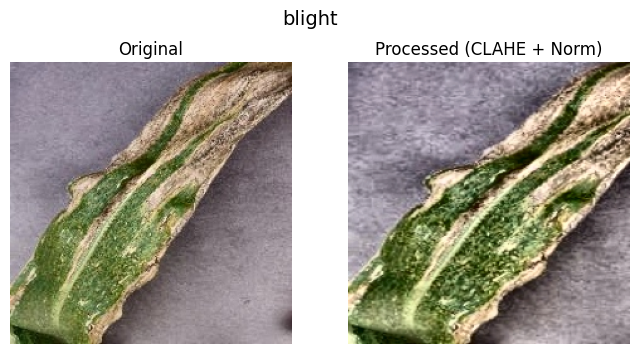

In [11]:
class_name = 'blight'
test_image_path = f'/content/blight_dataset_processed/Blight/Corn_Blight (1002).JPG'
original_img, processed_img = smart_leaf_crop(test_image_path, class_name)
if processed_img is not None:
    show_images(original_img, processed_img, title=class_name)
else:
    print("Leaf not detected in the image.")

In [12]:
import os
from tqdm import tqdm

# ✅ ইনপুট ও আউটপুট ফোল্ডার
input_root = '/content/extracted_thesis/data'
output_root = '/content/Maize'  # এখানে সেভ হবে

# ✅ সব ক্লাসের উপর লুপ চালাও
for class_name in os.listdir(input_root):
    class_path = os.path.join(input_root, class_name)
    if not os.path.isdir(class_path):
        continue

    # ✅ সেভ ফোল্ডার বানাও
    save_folder = os.path.join(output_root, class_name)
    os.makedirs(save_folder, exist_ok=True)

    # ✅ প্রতিটি ছবির উপর কাজ করো
    for img_name in tqdm(os.listdir(class_path), desc=f'Processing {class_name}'):
        img_path = os.path.join(class_path, img_name)
        save_path = os.path.join(save_folder, img_name)

        try:
            original_img, processed_img = smart_leaf_crop(img_path, class_name)
            if processed_img is not None:
                # [0–1] scale → [0–255] uint8 এ রূপান্তর
                img_uint8 = (processed_img * 255).astype('uint8')
                img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)
                cv2.imwrite(save_path, img_bgr)
        except Exception as e:
            print(f"Failed on {img_path}: {e}")

Processing Blight: 100%|██████████| 1146/1146 [00:06<00:00, 164.42it/s]


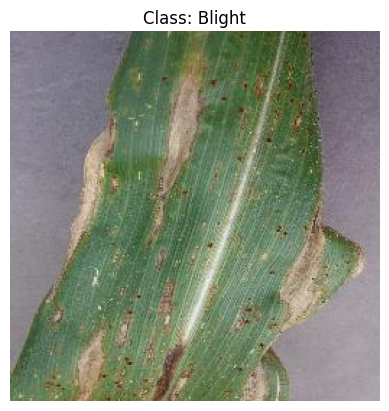

In [13]:
import os
import random
import matplotlib.pyplot as plt
from skimage.io import imread

# sob class folder list kora
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# ekti random class select
random_class = random.choice(classes)
class_path = os.path.join(dataset_path, random_class)

# sei class folder theke random image select
images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
random_image = random.choice(images)
img_path = os.path.join(class_path, random_image)

# image load & display
img_data = imread(img_path)
plt.imshow(img_data, cmap='gray')
plt.title(f"Class: {random_class}")
plt.axis('off')
plt.show()


# Data Split : 70 - 30  

In [14]:
# Create dataframe from image paths
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
import os

image_paths = glob(f'{'/content/Maize'}/*/*.*')
data = pd.DataFrame({
    'filepath': image_paths,
    'label': [os.path.basename(os.path.dirname(p)) for p in image_paths]
})

# Stratified Split
train_df, temp_df = train_test_split(data, test_size=0.3, stratify=data['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [15]:
#  Copy images to split folders
import shutil
from tqdm import tqdm

def copy_images(df, split_name, base_dir='/content/split'):
    for _, row in tqdm(df.iterrows(), total=len(df)):
        class_dir = os.path.join(base_dir, split_name, row['label'])
        os.makedirs(class_dir, exist_ok=True)
        shutil.copy(row['filepath'], class_dir)

copy_images(train_df, 'train')
copy_images(val_df, 'val')
copy_images(test_df, 'test')


100%|██████████| 629/629 [00:00<00:00, 4326.15it/s]


### Data augmentation

In [16]:
import os
import cv2
import albumentations as A
from tqdm import tqdm
import random

# ✅ Base directory of your extracted split dataset
base_train_dir = '/content/split/train'

# ✅ Desired target per class
TARGET_PER_CLASS = 2000

# ✅ Augmentation pipeline
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=30, p=0.5),
    A.RandomShadow(p=0.3),
    A.ZoomBlur(p=0.2),
   A.ShiftScaleRotate(p=0.3)
])


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [17]:
# ✅ Apply augmentation only to classes with fewer than target images
for class_name in os.listdir(base_train_dir):
    class_path = os.path.join(base_train_dir, class_name)
    images = os.listdir(class_path)
    current_count = len(images)

    print(f"📁 {class_name}: {current_count} images")

    if current_count >= TARGET_PER_CLASS:
        continue  # Skip if already enough

    to_generate = TARGET_PER_CLASS - current_count
    img_paths = [os.path.join(class_path, img) for img in images]

    for i in tqdm(range(to_generate), desc=f"🔄 Augmenting {class_name}"):
        img_path = random.choice(img_paths)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        augmented = augment(image=img)['image']
        save_path = os.path.join(class_path, f'aug_{i}_{os.path.basename(img_path)}')
        cv2.imwrite(save_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))


📁 Gray_Leaf_Spot: 402 images


🔄 Augmenting Gray_Leaf_Spot: 100%|██████████| 1598/1598 [00:04<00:00, 374.87it/s]


📁 Common_Rust: 914 images


🔄 Augmenting Common_Rust: 100%|██████████| 1086/1086 [00:04<00:00, 268.32it/s]


📁 Healthy: 813 images


🔄 Augmenting Healthy: 100%|██████████| 1187/1187 [00:02<00:00, 396.86it/s]


📁 Blight: 802 images


🔄 Augmenting Blight: 100%|██████████| 1198/1198 [00:03<00:00, 378.00it/s]


In [18]:
import os

dataset_path = '/content/split/train'

if not os.path.exists(dataset_path):
    print(f"❌ Dataset path not found: {dataset_path}")
else:
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            num_images = len([
                f for f in os.listdir(class_dir)
                if os.path.isfile(os.path.join(class_dir, f))
            ])
            class_counts[class_name] = num_images

    print(f"\n✅ Number of classes: {len(class_counts)}")
    print("📊 Images per class:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count} images")


✅ Number of classes: 4
📊 Images per class:
  Gray_Leaf_Spot: 2000 images
  Common_Rust: 2000 images
  Healthy: 2000 images
  Blight: 2000 images


Without parameter tuning

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions and batch size
img_width, img_height = target_size
batch_size = 32

# Path to the augmented dataset
augmented_dataset_path = '/content/split/train' # Use the augmented data

# Create data generators for augmented data
train_datagen = ImageDataGenerator(
    rescale=1./105,
    validation_split=0.2 # 20% for validation
)

train_generator = train_datagen.flow_from_directory(
    augmented_dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    augmented_dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')  # Output layer with number of classes
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


Found 6400 images belonging to 4 classes.
Found 1600 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the model
epochs = 50 # You can adjust the number of epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.5697 - loss: 1.3991 - val_accuracy: 0.8400 - val_loss: 0.4243
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.8375 - loss: 0.4208 - val_accuracy: 0.8406 - val_loss: 0.4118
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.8885 - loss: 0.2871 - val_accuracy: 0.8612 - val_loss: 0.3288
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - accuracy: 0.9236 - loss: 0.2145 - val_accuracy: 0.8619 - val_loss: 0.3599
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.9354 - loss: 0.1713 - val_accuracy: 0.8981 - val_loss: 0.3264
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.9636 - loss: 0.1038 - val_accuracy: 0.8969 - val_loss: 0.3336
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 81ms/step - accuracy: 0.9816 - loss: 0.0531 - val_accuracy: 0.8775 - val_loss: 0.4439
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.9850 - loss: 0.0519 - val_accurac

In [23]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(validation_generator)
print(f'\nValidation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9062 - loss: 1.0947

Validation Loss: 1.0426
Validation Accuracy: 0.9062


In [24]:
from sklearn.metrics import classification_report
import numpy as np

# Create test data generator (without augmentation and validation split)
test_datagen = ImageDataGenerator(rescale=1./255) # Rescale the same way as train/validation

test_generator = test_datagen.flow_from_directory(
    '/content/split/test', # Path to the test set
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Keep data in order for correct evaluation
)

# Get true labels and predicted labels
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get class names
class_names = list(test_generator.class_indices.keys())

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

Found 629 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step
                precision    recall  f1-score   support

        Blight       0.81      0.62      0.70       172
   Common_Rust       0.86      0.91      0.88       196
Gray_Leaf_Spot       0.48      0.79      0.60        86
       Healthy       0.99      0.83      0.90       175

      accuracy                           0.79       629
     macro avg       0.78      0.79      0.77       629
  weighted avg       0.83      0.79      0.80       629



#Confusion Matrix

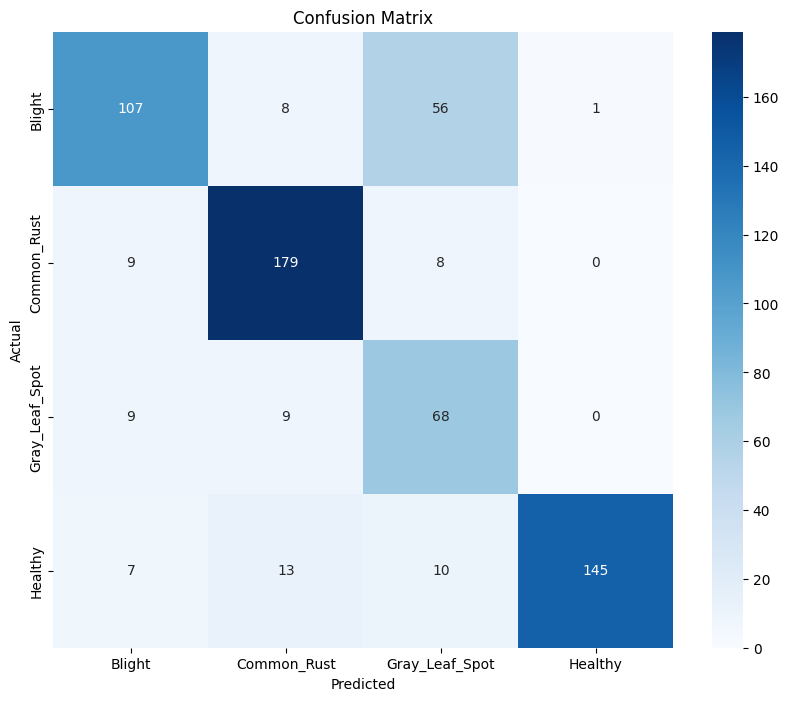

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_true and y_pred_classes are already defined from the previous cell
# If not, you would need to regenerate them here

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **ROC curve**

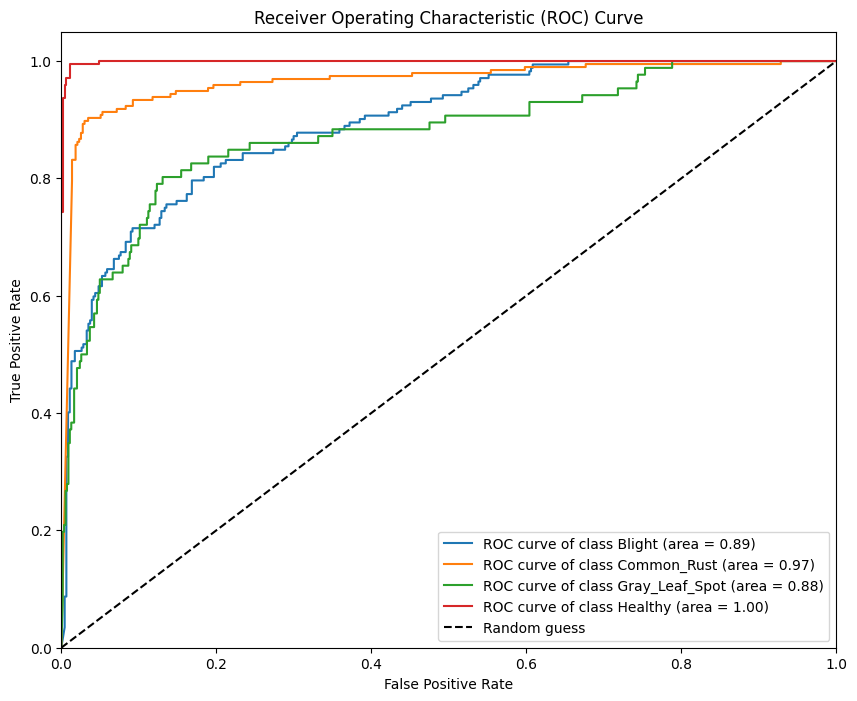

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_true, y_pred and class_names are already defined from previous cells

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Loss and Accuracy

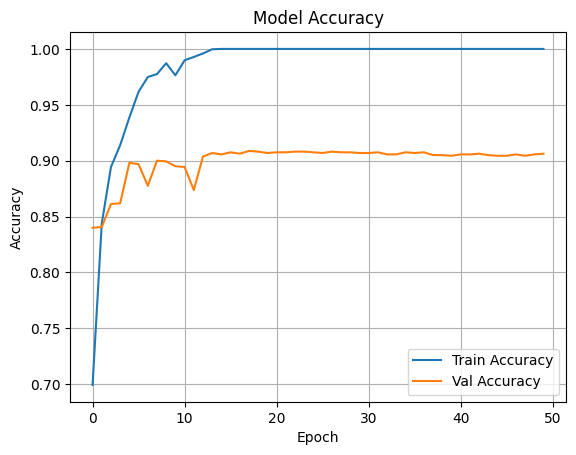

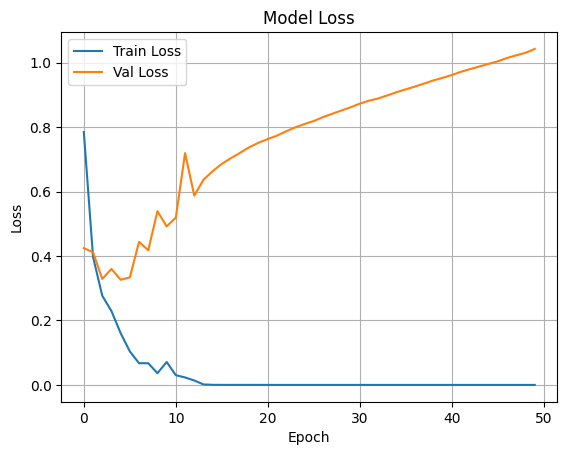

In [27]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# **With parameter tuning**

In [54]:
!pip install keras_tuner

In [58]:
# Create an instance of the Keras Tuner
tuner = kt.RandomSearch(
    hypermodel=build_model,  # Pass the model building function
    objective="val_accuracy", # The metric to optimize (e.g., validation accuracy)
    max_trials=10,           # Total number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to train for each combination (for stability)
    directory="my_tuner_dir", # Directory to save tuning results
    project_name="image_classifier"
)

In [60]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define the model building function for Keras Tuner
def build_model(hp):
    model = Sequential()

    # Example: Hyperparameters for Conv2D layers
    hp_filters = hp.Int('filters', min_value=32, max_value=128, step=32)
    hp_kernel = hp.Choice('kernel_size', values=[3, 5])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-4])

    # First convolutional block
    model.add(Conv2D(hp_filters, (hp_kernel, hp_kernel), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))

    # Second convolutional block
    model.add(Conv2D(hp_filters * 2, (hp_kernel, hp_kernel), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten the output for the dense layers
    model.add(Flatten())

    # Add the dense layer with a dynamically determined input shape
    # Keras will automatically infer the input shape from the Flatten layer's output
    model.add(Dense(hp.Int('units', min_value=32, max_value=256, step=32), activation='relu'))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [61]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import os

# Define the model building function for Keras Tuner
def build_model(hp):
    model = Sequential()

    # Define hyperparameters for the convolutional layers
    hp_filters = hp.Int('filters', min_value=32, max_value=128, step=32)
    hp_kernel = hp.Choice('kernel_size', values=[3, 5])
    # Define a smaller range for the learning rate to prevent exploding loss
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])

    # First convolutional block
    model.add(Conv2D(hp_filters, (hp_kernel, hp_kernel), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))

    # Second convolutional block
    model.add(Conv2D(hp_filters * 2, (hp_kernel, hp_kernel), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten the output for the dense layers
    model.add(Flatten())

    # Add the dense layer. Keras will automatically infer the input shape.
    model.add(Dense(hp.Int('units', min_value=32, max_value=256, step=32), activation='relu'))

    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with the chosen learning rate
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# ---

# Create an instance of the Keras Tuner
# We'll use RandomSearch to find the best hyperparameters
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="my_tuner_dir",
    project_name="image_classifier_tuning"
)

# ---

# Prepare the data generators
# Make sure the paths '/content/split/train' and '/content/split/val' exist
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/split/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# ---

# Start the hyperparameter search
tuner.search(train_generator,
             epochs=50,
             validation_data=validation_generator)

# Get the best model after the search is complete
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Reloading Tuner from my_tuner_dir/image_classifier_tuning/tuner0.json
Found 8000 images belonging to 4 classes.
Found 628 images belonging to 4 classes.

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
64                |96                |filters
3                 |3                 |kernel_size
0.0001            |0.0001            |learning_rate
224               |256               |units



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.12/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/keras_tuner/src/engine/tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
            ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/keras_tuner/src/engine/tuner.py", line 164, in _try_b

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.12/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/keras_tuner/src/engine/tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
            ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/keras_tuner/src/engine/tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/keras_tuner/src/engine/tuner.py", line 155, in _build_hypermodel
    model = self.hypermodel.build(hp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3330089426.py", line 30, in build_model
    model.add(Dense(hp.Int('units', min_value=32, max_value=256, step=32), activation='relu'))
  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/sequential.py", line 122, in add
    self._maybe_rebuild()
  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/sequential.py", line 149, in _maybe_rebuild
    self.build(input_shape)
  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 232, in build_wrapper
    original_build_method(*args, **kwargs)
  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/sequential.py", line 195, in build
    x = layer(x)
        ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/random.py", line 34, in uniform
    return tf.random.stateless_uniform(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tensorflow.python.framework.errors_impl.ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul] name: 
